## SETUP inicial
Aqui importamos as principais bibliotecas e definimos algumas configurações para a exploração dos dados. 
Vou utilizar um random state fixo de 42 para garantir a reprodutibilidade do modelo

### Objetivo
Desenvolver, treinar e avaliar modelos preditivos para estimar a probabilidade da variável target (y), utilizando os dados tratados no Notebook 2, respeitando a separação temporal e avaliando o desempenho por métricas adequadas ao problema de crédito.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


Aqui vamos importar os dados do notebook 2 já pré-processados

In [2]:
# Treino
df_mediana = pd.read_csv('../data/processed/treino_mediana.csv')
df_media = pd.read_csv('../data/processed/treino_media.csv')
df_mediana_flag = pd.read_csv('../data/processed/treino_mediana_flag.csv')

# Validação
df_validacao_mediana = pd.read_csv('../data/processed/validacao_mediana.csv')
df_validacao_media = pd.read_csv('../data/processed/validacao_media.csv')
df_validacao_mediana_flag = pd.read_csv('../data/processed/validacao_mediana_flag.csv')

# Teste
df_teste_mediana = pd.read_csv('../data/processed/teste_mediana.csv')
df_teste_media = pd.read_csv('../data/processed/teste_media.csv')
df_teste_mediana_flag = pd.read_csv('../data/processed/teste_mediana_flag.csv')



Agora vamos definir algumas funções para separar as features da variavel target e para treinar o modelo e trazer as métricas.

In [ ]:
def separa_xy(df):
    X = df.drop(columns=['id', 'safra', 'y'], errors='ignore')
    y = df['y']
    return X, y


In [7]:
def treinar_e_avaliar(X_train, y_train, X_valid, y_valid):
    model = LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    auc = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    ks = max(tpr - fpr)
    gini = 2 * auc - 1
    
    return model, y_pred_proba, auc, ks, gini


In [8]:
pipelines = {
    'Mediana': (df_mediana, df_validacao_mediana),
    'Média': (df_media, df_validacao_media),
    'Mediana + Flag': (df_mediana_flag, df_validacao_mediana_flag)
}

resultados = []

for nome, (df_train, df_valid) in pipelines.items():
    X_train, y_train = separa_xy(df_train)
    X_valid, y_valid = separa_xy(df_valid)
    
    model, y_pred, auc, ks, gini = treinar_e_avaliar(X_train, y_train, X_valid, y_valid)
    
    resultados.append({
        'Pipeline': nome,
        'AUC': auc,
        'KS': ks,
        'Gini': gini,
        'Modelo': model,
        'y_pred': y_pred
    })

resultados_df = pd.DataFrame(resultados)
resultados_df[['Pipeline', 'AUC', 'KS', 'Gini']]


c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-

,Pipeline,AUC,KS,Gini
0,Mediana,0.716138,0.319712,0.432275
1,Média,0.719282,0.322622,0.438565
2,Mediana + Flag,0.715588,0.320723,0.431175


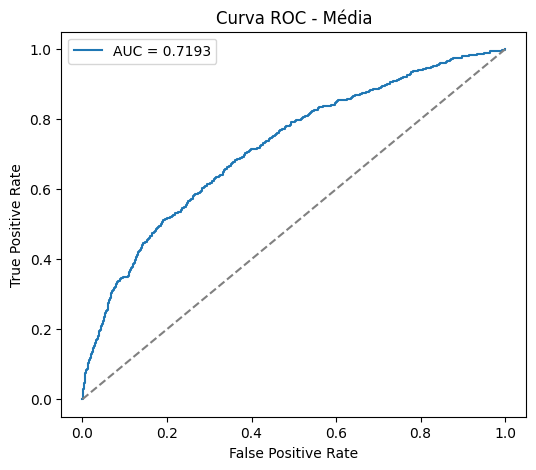

In [9]:
# Seleciona o melhor pipeline (maior AUC)
melhor_idx = resultados_df['AUC'].idxmax()
melhor_pipeline = resultados_df.loc[melhor_idx, 'Pipeline']
melhor_modelo = resultados_df.loc[melhor_idx, 'Modelo']
y_pred_best = resultados_df.loc[melhor_idx, 'y_pred']

# Dados de validação correspondentes
_, y_valid_best = separa_xy(pipelines[melhor_pipeline][1])

# Curva ROC
fpr, tpr, _ = roc_curve(y_valid_best, y_pred_best)
auc_best = roc_auc_score(y_valid_best, y_pred_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_best:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - {melhor_pipeline}')
plt.legend()
plt.show()


In [10]:
X_train_best, _ = separa_xy(pipelines[melhor_pipeline][0])

coef_df = pd.DataFrame({
    'Variável': X_train_best.columns,
    'Coeficiente': melhor_modelo.coef_[0]
}).sort_values('Coeficiente', ascending=False)

coef_df.head(10)


,Variável,Coeficiente
9,VAR_33,0.022984
0,VAR_1,0.020937
4,VAR_19,0.009019
11,VAR_9,0.001052
17,VAR_72,0.000106
12,VAR_53,0.000069
3,VAR_65,-0.000055
16,VAR_54,-0.000111
13,VAR_30,-0.000379
1,VAR_6,-0.000401


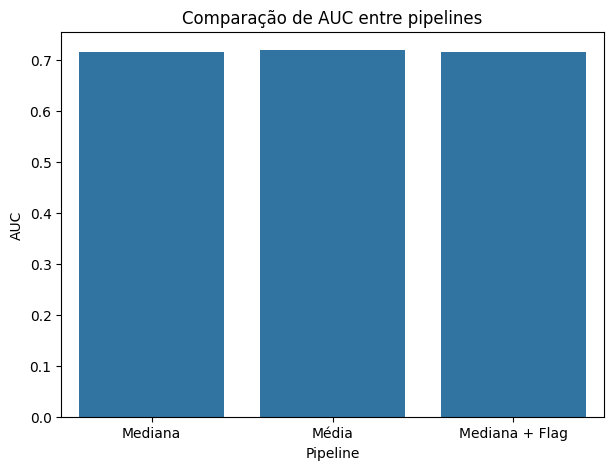

In [11]:
plt.figure(figsize=(7,5))
sns.barplot(x='Pipeline', y='AUC', data=resultados_df)
plt.title('Comparação de AUC entre pipelines')
plt.show()
